In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [2]:
#NEW DATA TEST
caiso=pd.read_csv("/Users/john_schafer/Downloads/CE291/CAISO_zone_1_.csv")

In [3]:
#Transform Data to our format
caiso['time'] = pd.to_datetime(caiso['time'])
caiso.set_index('time', inplace=True)

# Function to reshape the data
def reshape_data(df, column):
    # Resample data to daily frequency, and apply list to convert each day's data into a list
    daily_data = df[column].resample('D').apply(list)
    # Convert lists to a DataFrame, which inherently transposes the list to columns
    return pd.DataFrame(daily_data.tolist(), index=daily_data.index)

# Creating each DataFrame
demand_df = reshape_data(caiso, 'load_power')
solar_df = reshape_data(caiso, 'solar_power')
wind_df = reshape_data(caiso, 'wind_power')

def rename_columns(df):
    num_minutes = df.shape[1]
    time_labels = [str(pd.Timedelta(minutes=i)) for i in range(num_minutes)]
    df.columns = time_labels
    return df

demand_df = rename_columns(demand_df)
solar_df = rename_columns(solar_df)
wind_df = rename_columns(wind_df)

In [4]:

#Scaling 
# if power is normalized to 1, PEV dynamics in environment are run in kw
#max power of single Ev = 11 kw 
#max power of representative small microgrid of 5,000 people ~ 3.5 megawatts=3,500 kw
#multiply vby 3500 to get representative 
demand_caiso = np.array(demand_df)
solar_caiso = np.array(solar_df)*3 
wind_caiso = np.array(wind_df)*4 
net_caiso=demand_caiso-solar_caiso-wind_caiso

average_demand_per_minute = np.nanmean(demand_caiso, axis=0)
average_solar_per_minute = np.nanmean(solar_caiso, axis=0)
average_wind_per_minute = np.nanmean(wind_caiso, axis=0)

average_net_per_minute=average_demand_per_minute-average_solar_per_minute-average_wind_per_minute

In [5]:
#Sample only every ten minutes
average_demand_10min= average_demand_per_minute[::10]
average_solar_10min= average_solar_per_minute[::10]
average_wind_10min= average_wind_per_minute[::10]

average_net_10min=average_demand_10min-average_solar_10min-average_wind_10min

average_demand_10min= average_demand_10min.reshape(144,1).T
average_solar_10min=average_solar_10min.reshape(144,1).T
average_wind_10min=average_wind_10min.reshape(144,1).T

In [6]:
from AGENT_CRITIC import AGENT_CRITIC
from env_rnn import GridEnvironment

In [7]:
#Testing Max Entropy Technique
import time
timestep_length=(10/60) #in hours
N=800
sequence_length=12 #In timesteps aka minutes
state_deque = deque(maxlen=sequence_length)
day_index=0

# Initialize DQN agent
agent = AGENT_CRITIC(state_size=3, action_size=21, sequence_length=sequence_length)

episode_durations = []

for episode in range(10):  # Loop over 3 episodes of same "average" day
    # Initialize environment for the current day
    start_time = time.time()
    env = GridEnvironment(N, average_demand_10min, average_solar_10min, average_wind_10min, day_index, timestep_length)
    
    total_reward = 0
    T = 144  # Assume T timesteps in a day

    demand_profile = np.zeros(T)
    solar_profile = np.zeros(T)
    wind_profile = np.zeros(T)
    PEV_profile = np.zeros(T)

    for timestep in range(1, T + 1):
        current_demand, current_solar, current_wind, current_SoC = env.get_state()
        current_state=np.concatenate([np.array([current_demand, current_solar, current_wind])])

        state_deque.append(current_state)
        state_history = np.array(state_deque)

        if len(state_deque) < sequence_length:
            continue  # Skip until we have enough data

        action = agent.act(state_history)
        reward, done, next_demand, next_solar, next_wind, next_P_EV, next_SoC = env.step(action)

        demand_profile[timestep - 1] = next_demand
        solar_profile[timestep - 1] = next_solar
        wind_profile[timestep - 1] = next_wind
        PEV_profile[timestep - 1] = np.sum(next_P_EV)
        
        next_state = np.concatenate([np.array([next_demand, next_solar, next_wind])])

        agent.learn(state_history, action, reward, next_state, done)
        total_reward += reward

        if done:
            break

    print(f"Total reward for episode {episode}: {total_reward}")
    episode_durations.append(time.time() - start_time)

print("Individual episode durations:", episode_durations)

2024-04-24 13:46:19.166348: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Total reward for episode 0: -119.98685808236374
Total reward for episode 1: -128.02282911610254
Total reward for episode 2: -127.26472498713329
Total reward for episode 3: -128.6227099437101
Total reward for episode 4: -93.51356811887129
Total reward for episode 5: -109.94790170967288
Total reward for episode 6: -107.13782503709892
Total reward for episode 7: -101.21945135836964
Total reward for episode 8: -104.7968179575462
Total reward for episode 9: -102.3630234967968
Individual episode durations: [19.4820499420166, 19.36401915550232, 18.243937969207764, 18.287484884262085, 18.106571912765503, 18.351112127304077, 18.00438904762268, 18.28206467628479, 18.206203937530518, 17.83795189857483]


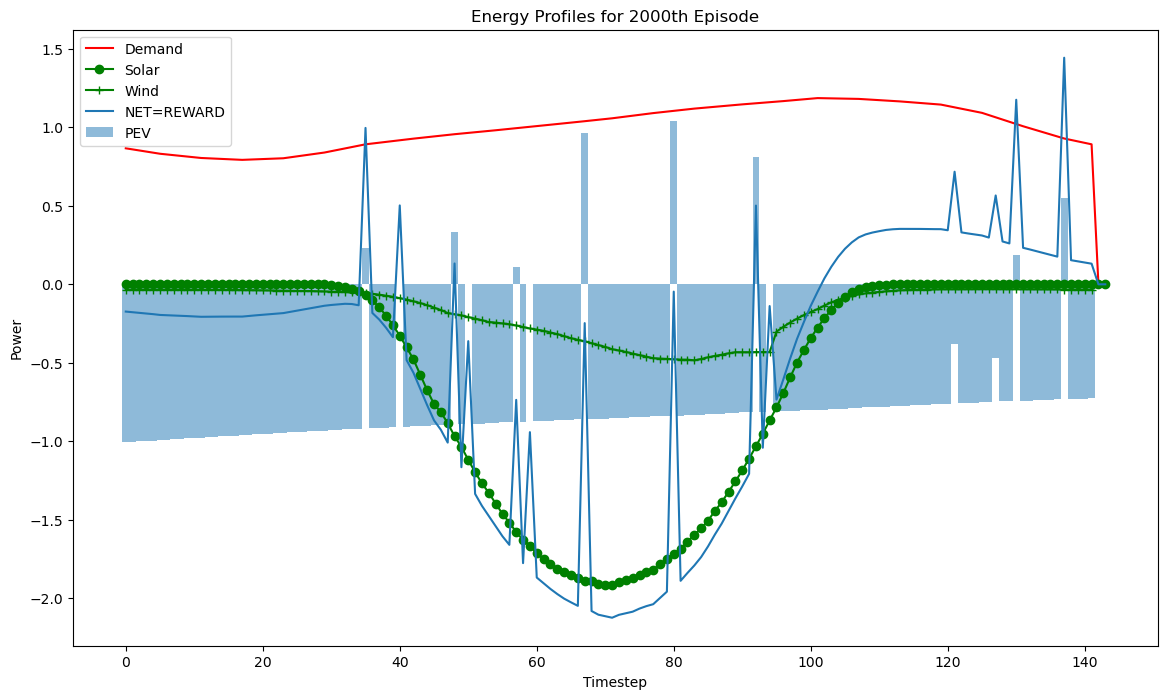

In [9]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile, label='Demand', color="red")
plt.plot(-1*solar_profile, label='Solar', color='green', marker='o')
plt.plot(-1*wind_profile, label='Wind', color='green', marker='+')

plt.plot(demand_profile+PEV_profile -solar_profile- wind_profile, label='NET=REWARD')

# Plot the PEV_profile as a bar graph
timesteps = np.arange(len(PEV_profile))  
plt.bar(timesteps, PEV_profile, width=1.0, label='PEV', alpha=0.5)  



plt.legend()
plt.title('Energy Profiles for 2000th Episode')
plt.xlabel('Timestep')
plt.ylabel('Power')
#plt.savefig('2000_RNN_perc_action.png')
plt.show()